In [1]:
#import healpy as hp
import astropy_healpix.healpy as ahp
from astropy_healpix import HEALPix
from hpmoc.healpy import healpy as hhp
from hpmoc.utils import N_X_OFFSET, N_Y_OFFSET, FONT_SIZE
from hpmoc.plotters import outline_effect
from hpmoc.plot import get_wcs, get_frame_class, _WCS_HEADERS
from hpmoc.points import PointsTuple, Rgba
from astropy.units import Unit, deg
from matplotlib import pyplot as plt, cm
import numpy as np
import hpmoc
from hpmoc.partial import PartialUniqSkymap
from reproject import reproject_from_healpix, reproject_to_healpix
import astropy as ap
from astropy.units import deg, rad, Unit, Quantity
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization.wcsaxes import WCSAxes, WCSAxesSubplot
from astropy.visualization.wcsaxes.frame import EllipticalFrame, RectangularFrame
from astropy.coordinates import FK5
#https://docs.astropy.org/en/stable/visualization/wcsaxes/generic_transforms.html
from matplotlib.transforms import Affine2D
from matplotlib.projections import projection_registry
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation

In [2]:
SKYMAP = "../tests/data/S191216ap.fits.gz"
hdu_head, hdu_ligo = fits.open(SKYMAP)[:2]
m = PartialUniqSkymap.read(SKYMAP, strategy='ligo')
mo = PartialUniqSkymap.read("../tests/data/S191216ap.multiorder.fits", strategy='ligo')
# https://github.com/lpsinger/ligo.skymap/blob/main/ligo/skymap/plot/allsky.py#L791
target_header = fits.Header.fromstring("""
NAXIS   =                    2
NAXIS1  =                  480
NAXIS2  =                  240
CTYPE1  = 'RA---MOL'
CRPIX1  =                240.5
CRVAL1  =                180.0
CDELT1  =               -0.675
CUNIT1  = 'deg     '
CTYPE2  = 'DEC--MOL'
CRPIX2  =                120.5
CRVAL2  =                  0.0
CDELT2  =                0.675
CUNIT2  = 'deg     '
COORDSYS= 'icrs    '
""", sep='\n')
target_header['CDELT1'] = -np.sqrt(8)/np.pi*360/target_header['NAXIS1']
target_header['CDELT2'] = np.sqrt(8)/np.pi*180/target_header['NAXIS2']
w = WCS(target_header)
wh = WCS(hdu_ligo.header)
pts = PointsTuple(
    points=[
        (271., 31., 2., 'One'),
        (355., -44., 3.),
        (15., -62., 5.),
        (16., -60., 3.),
        (10., -30., 10.),
    ],
    rgba=Rgba(0, 1, 0, 0.3),
    marker='x',
    label='Test Points',
)
mo.point_sources = [pts]
mr = m.render(w)
mor = mo.render(w)
array2, footprint2 = reproject_from_healpix("../tests/data/S191216ap.fits.gz",
                                            target_header, nested=True)

E:\miniconda3\envs\hpmoc-dev-win\lib\site-packages\astropy_healpix\core.py:516: RuntimeWarning: invalid value encountered in bilinear_interpolation_weights
  result = _core.bilinear_interpolation_weights(lon, lat, nside)
E:\miniconda3\envs\hpmoc-dev-win\lib\site-packages\astropy_healpix\core.py:481: RuntimeWarning: invalid value encountered in ring_to_nested
  return _core.ring_to_nested(ring_index, nside)


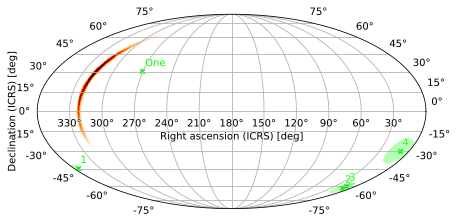

In [3]:
mo.plot()

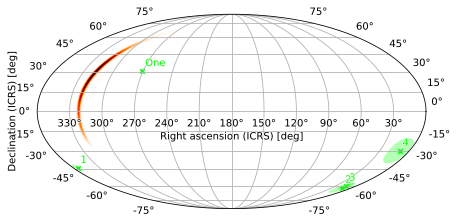

In [4]:
mo.plot(width=720, height=360)

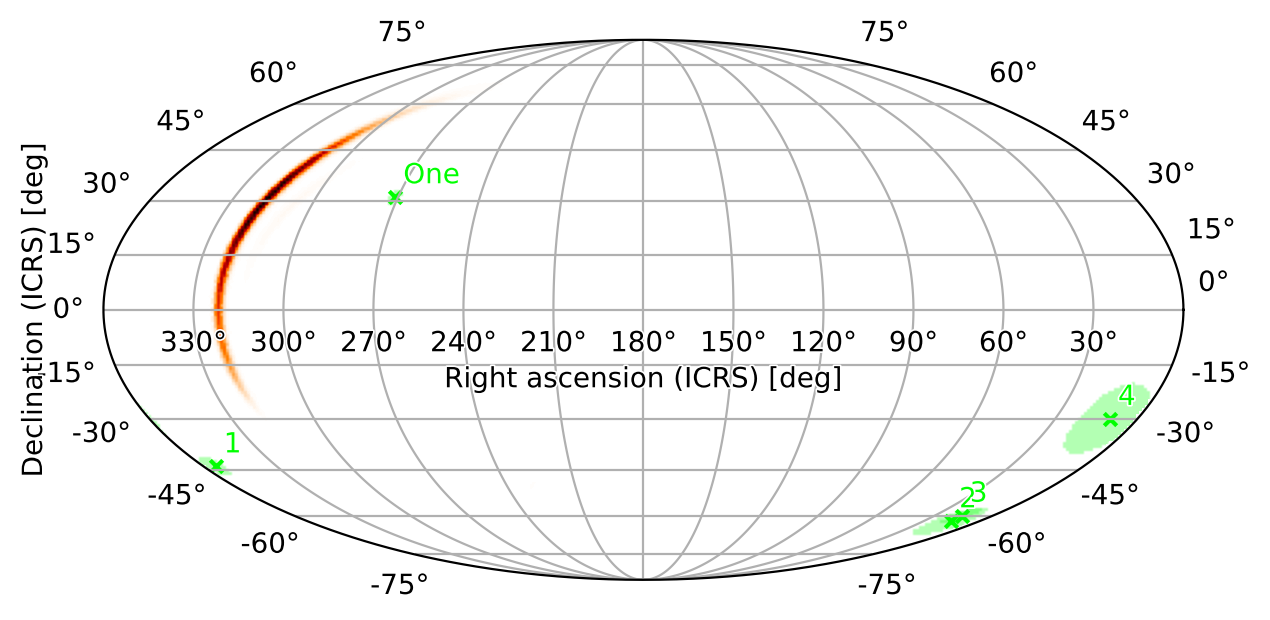

In [5]:
fig = plt.figure(dpi=200)
mo.plot(fig=fig)

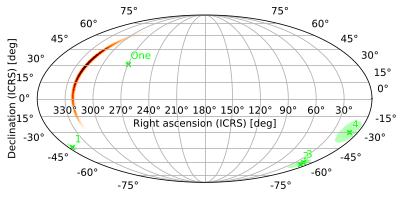

In [3]:
# plot it
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection=w,
                     frame_class=EllipticalFrame)
                     #frame_class=RectangularFrame)

# format ticks and grid
outline = [outline_effect()]
co_ra, co_dec = ax.coords
co_ra.set_major_formatter("dd")
co_dec.set_major_formatter("dd")
co_ra.set_ticks(np.arange(30, 360, 30)*deg)
co_dec.set_ticks(np.arange(-75, 90, 15)*deg)
co_ra.set_ticklabel(size=10, path_effects=outline)
co_dec.set_ticklabel(size=10, path_effects=outline)
co_ra.set_ticks_visible(False)
co_dec.set_ticks_visible(False)
co_ra.set_axislabel("Right ascension (ICRS) [deg]", size=10, path_effects=outline)
co_dec.set_axislabel("Declination (ICRS) [deg]", size=10, path_effects=outline)
ax.grid(True)

# add the skymap
ax.imshow(mor, cmap='gist_heat_r')#cm.gist_heat_r)
ax.imshow(pts.render(w), vmin=0, vmax=1, cmap=pts.cmap())
ax.scatter(*np.array([(r, d) for (r, d, *_) in pts.points]).T,
           s=20,
           c=pts.rgba.to_hex()[:-2], marker=pts.marker,
           transform=ax.get_transform('world'))
for i, (r, d, *sl) in enumerate(pts.points):
    if len(sl) == 2:
        l = sl[1]
    else:
        l = str(i)
    ax.text(r, d, l, va='bottom', ha='left', path_effects=outline,
            color=pts.rgba.to_hex(False), fontsize=10,
            transform=ax.get_transform('world') + ScaledTranslation(
                N_X_OFFSET*.5, N_Y_OFFSET*.5, ax.figure.dpi_scale_trans
            ))
#ax.imshow(array2)

In [8]:
ax.scatter?

In [46]:
type(cm.gist_heat_r).__base__

matplotlib.colors.Colormap

In [21]:
pr = pts.render(w)
np.unique(pr[~np.isnan(pr)])

array([0.        , 0.10000002, 0.19000006])

In [4]:
ax.scatter()

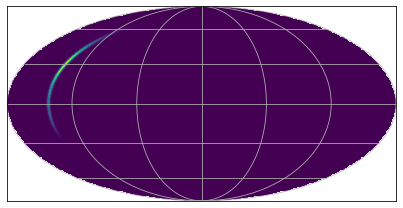

In [48]:
fig = plt.figure()
ax2 = WCSAxes(fig, rect=[0.1, 0.1, 0.9, 0.9], wcs=w,
              frame_class=RectangularFrame)#EllipticalFrame)
fig.add_axes(ax2)
ax2.imshow(mor, vmin=-1e-10)
ax2.grid(True)

In [32]:
fig.subplots?

In [ ]:
type(ax)

In [ ]:
ax.wcs

In [ ]:
target_header['CDELT1']

In [ ]:
w.to_header()

In [ ]:
x = 'foobar'
x[3] = ' '
x

In [134]:
from textwrap import wrap, indent
indent('\n'.join(wrap(f"{', '.join(['a', 'b', 'c'])} bar", 79)), ' '*6)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---CAR'  'DEC--CAR'  
CRVAL : 180.0  30.0  
CRPIX : 480.5  240.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.3376186186  0.3376186186  
NAXIS : 960  480

In [ ]:
w.to_header()

- [Some examples of setting the coordinate formatter](https://wcsaxes.readthedocs.io/en/latest/ticks_labels_grid.html)
- [Seemingly same site here](https://docs.astropy.org/en/stable/visualization/wcsaxes/ticks_labels_grid.html)
- [WCS Example FITS files](https://www.atnf.csiro.au/people/mcalabre/WCS/example_data.html)

In [ ]:
pts

In [ ]:
m.mollview()

In [ ]:
hdu_ligo.header